<a href="https://colab.research.google.com/github/DanyWind/variationnal_dropout/blob/master/AutoDropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoDropout implementation 

In [47]:

import torch
import torch.nn as nn
from torch.distributions import Bernoulli

inverse_sigmoid = lambda p: torch.log(p/(1-p))

class PLU(nn.Module):
    """Probability Linear Unit"""

    def __init__(self):
        super(PLU, self).__init__()

    def forward(self, x):
        z = torch.clamp(x, 0, 1)
        return z


class CustomDropout(nn.Module):
    """Custom Dropout module to be used as a baseline for MC Dropout"""

    def __init__(self, p, activate=True):
        super().__init__()
        self.activate = activate
        self.p = p

    def forward(self, x):
        return nn.functional.dropout(x, self.p, training=self.activate)


class AutoDropout(nn.Module):
    def __init__(self, dp=0., requires_grad=False):

        super(AutoDropout, self).__init__()

        # We transform the dropout rate to keep rate
        p = 1 - dp
        p = torch.tensor(p)
        
        gamma = inverse_sigmoid(p)

        if requires_grad:
            gamma = nn.Parameter(gamma)
            self.register_parameter("gamma", gamma)
        else:
            self.register_buffer("gamma", gamma)

    def forward(self, x):
        bs, shape = x.shape[0], x.shape[1:]

        # We make sure p is a probability
        p = torch.sigmoid(self.gamma)

        ps = p.expand(shape)

        m = Bernoulli(ps).sample((1,)).squeeze(0)

        m  = ps + (m - ps).detach()
        
        # Element wise multiplication
        z = x * m

        return z

    def extra_repr(self):
        return 'p={}'.format(torch.sigmoid(self.gamma))


class DropLinear(nn.Module):
    def __init__(self, in_features, out_features, dp=0., bias=True, requires_grad=False):
        super(DropLinear, self).__init__()

        self.dp = AutoDropout(dp=dp, requires_grad=requires_grad)
        self.W = nn.Linear(in_features=in_features,
                           out_features=out_features, bias=bias)
        self.W.weight.data = self.W.weight.data / self.W.weight.data.norm() * (1-dp)

    def forward(self, x):
        z = self.W(x)
        z = self.dp(z)
        return z


In [79]:

from fastai.callbacks.hooks import HookCallback
from fastai.torch_core import to_np

import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


def norm2(x): return (x**2).sum()


def neg_entropy(p): return p * torch.log(p) + (1-p) * torch.log(1-p)


def get_layer(m, buffer, layer):
    """Function which takes a list and a model append the elements"""
    for c in m.children():
        if isinstance(c, layer):
            if isinstance(buffer, list):
                buffer.append(c)
            elif isinstance(buffer, dict):
                i = hex(id(c))
                buffer[i] = c
        get_layer(c, buffer, layer)


class CustomActivationStats(HookCallback):
    def __init__(self, learn, layer_type, do_remove: bool = True):
        super().__init__(learn)

        buffer = []
        get_layer(learn.model, buffer, layer_type)
        if not buffer:
            raise NotImplementedError(f"No {layer_type} Linear found")

        self.modules = buffer
        self.do_remove = do_remove

        self.stats = []

    def hook(self, m, i, o):
        mean = o.mean().item()
        std = o.std().item()
        z = to_np(o.mean(dim=0))

        i = hex(id(m))
        self.stats.append({"m": mean, "s": std, "z": z, "module": i})

    @property
    def df(self): return pd.DataFrame(self.stats)


class KLHook(HookCallback):
    """Hook to register the parameters of the latents during the forward pass to compute the KL term of the VAE"""

    def __init__(self, learn, do_remove: bool = True, recording=False,beta=1):
        super().__init__(learn)

        # First we store all the DropLinears layers to hook them
        buffer = []
        get_layer(learn.model, buffer, DropLinear)
        if not buffer:
            raise NotImplementedError(f"No {DropLinear} Linear found")

        self.modules = buffer
        self.do_remove = do_remove

        # We will store the KL of each DropLinear here before summing them
        self.kls = []

        self.recording = recording

        if recording:
            self.stats = []
            self.loss = []
        
        self.beta = beta
        
    def on_backward_begin(self, last_loss, **kwargs):
        total_kl = 0
        for kl in self.kls:
            total_kl += kl
            
        total_loss = last_loss + total_kl

        if self.recording:
            self.loss.append({"total_kl": total_kl.item(), "last_loss": last_loss.item(),
                              "total_loss": total_loss.item()})

        # We empty the buffer of kls
        self.kls = []

        return {"last_loss": total_loss}

    def hook(self, m: nn.Module, i, o):
        "Save the latents of the bottleneck"
        bs = o.shape[0]

        p = torch.sigmoid(m.dp.gamma)

        ne = neg_entropy(p)

        W = m.W.weight
        norm_w = norm2(W)

        b = m.W.bias
        norm_b = norm2(b)

        kl = (p * norm_w + ne + norm_b) * self.beta

        self.kls.append(kl)

        if self.recording:
            i = hex(id(m))
            self.stats.append(
                {"dropout": 1 - p.item(), "w": norm_w.item(), "ne": ne.item(), "module": i})

    @property
    def df_stats(self): return pd.DataFrame(self.stats)

    @property
    def df_loss(self): return pd.DataFrame(self.loss)

    def plot_stats(self, module=None):
        assert self.recording, "Recording mode was off during initialization"
        df = self.df_stats
        if module:
            df = df.loc[df.module == module]

        fig, ax = plt.subplots(3, 1, figsize=(16, 12))

        ax[0].plot(df.w.values)
        ax[0].set_title("Weight norm")

        ax[1].plot(df.dropout.values)
        ax[1].set_title("Dropout rate")

        ax[2].plot(df["ne"].values)
        ax[2].set_title("Negative entropy")

    def plot_losses(self):
        assert self.recording, "Recording mode was off during initialization"
        df = self.df_loss
        df.plot()


## Rossmann stores

In [1]:
from fastai.tabular import *

In [2]:
path = Path()

In [3]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [4]:
procs=[FillMissing, Categorify, Normalize]

cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [5]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [6]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
valid_idx = range(cut)

In [7]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [8]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [9]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [10]:
def convert_layers(model,original,replacement,get_args=None,additional_args=None,final_layer_id=None):
    for child_name, child in model.named_children():
        i = hex(id(child))
        if isinstance(child, original) and i != final_layer_id:
            if get_args: 
                original_args = get_args(child)
            else:
                original_args = {}
            
            # If we want to provide additional args
            if additional_args: 
                args = {**original_args,**additional_args}
            else:
                args = original_args
            
            old_layer = getattr(model,child_name)
            new_layer = replacement(**args)
            
            setattr(model, child_name, new_layer)
        else:
            convert_layers(child,original,replacement,get_args,additional_args,final_layer_id)

def remove_layers(model,m_to_del):
    to_del = []
    for k,c in model._modules.items():
        if isinstance(c,m_to_del):
            to_del.append(k)
    for k in to_del:
        del model._modules[k]


In [124]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.05,0.05], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)


In [125]:
final_layer_id = hex(id(learn.model.layers[-1]))

In [126]:
from autodropout import CustomDropout

In [127]:
get_args = lambda drop : {"p":drop.p}
additional_args = {}

convert_lin_to_droplin = partial(convert_layers,original = nn.Dropout,replacement = CustomDropout,
                                 get_args=get_args,additional_args=additional_args)

In [128]:
convert_lin_to_droplin(learn.model)

In [129]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): CustomDropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


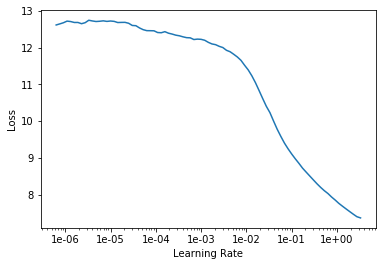

In [30]:
learn.lr_find()
learn.recorder.plot()

In [32]:
from callbacks import CustomActivationStats

In [130]:
learn.data.batch_size = 512
cb = CustomActivationStats(learn,layer_type=nn.Linear)
learn.fit_one_cycle(5,1e-2,callbacks=cb)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.043661,0.037635,0.193209,00:28
1,0.017784,0.020297,0.168721,00:27
2,0.013352,0.017558,0.123367,00:27
3,0.011148,0.013977,0.119258,00:27
4,0.009809,0.015208,0.128555,00:27


In [131]:
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.012660,0.017855,0.122049,00:26
1,0.013935,0.013435,0.117268,00:26
2,0.010712,0.012952,0.120559,00:26
3,0.009073,0.012546,0.113333,00:26
4,0.007750,0.013681,0.115055,00:26


In [133]:
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010416,0.013932,0.118308,00:26
1,0.010781,0.014636,0.121650,00:26
2,0.009373,0.012595,0.112537,00:26
3,0.008485,0.012189,0.110885,00:26
4,0.007589,0.011867,0.110691,00:26


In [134]:
learn.save("model_5dp_stage3")

In [150]:
switch_custom_dropout(learn.model,False,True)

Current active : False
Switching to : False
Current active : False
Switching to : False
Current active : False
Switching to : False


In [153]:
pred,y = learn.get_preds()
mse = learn.loss_func(pred,y)
rmse = exp_rmspe(pred,y)
print(mse)
print(rmse)

tensor(0.0107)
tensor(0.1074)


In [154]:
switch_custom_dropout(learn.model,True,True)

Current active : False
Switching to : True
Current active : False
Switching to : True
Current active : False
Switching to : True


In [155]:
pred,y = get_preds_sample(learn,n_sample=20)
pred = pred.mean(dim=0)
mse = learn.loss_func(pred,y)
rmse = exp_rmspe(pred,y)
print(mse)
print(rmse)

tensor(0.0107)
tensor(0.1078)


In [34]:
def get_preds_sample(learn,ds_type=DatasetType.Valid,n_sample=10,reduce=None):
  
    preds = []
    for i in range(n_sample):
        pred,y = learn.get_preds(ds_type=ds_type)
        pred = pred.view((1,) + pred.shape)
        preds.append(pred)
    preds = torch.cat(preds)
    if reduce == "mean":
        preds = preds.mean(dim=0)
    return preds,y 

In [141]:
def switch_custom_dropout(m,activate=True,verbose=False):
    for c in m.children():
        if isinstance(c, CustomDropout):
            print(f"Current active : {c.activate}")
            print(f"Switching to : {activate}")
            c.activate = activate
        else:
            switch_custom_dropout(c,activate=activate)

In [56]:
switch_custom_dropout(learn.model,False,True)

Current active : True
Switching to : False
Current active : True
Switching to : True
Current active : True
Switching to : True


In [57]:
pred, y = learn.get_preds()
learn.loss_func(pred,y)

tensor(0.0119)

In [58]:
exp_rmspe(pred,y)

tensor(0.1158)

In [61]:
switch_custom_dropout(learn.model,True,True)

Current active : True
Switching to : True
Current active : True
Switching to : True
Current active : True
Switching to : True


In [62]:
preds,y = get_preds_sample(learn)

In [73]:
np.quantile(to_np(preds.std(dim=0)).reshape(-1),0.99)

0.07590417563915242

In [55]:
exp_rmspe(preds,y)

tensor(0.1123)

In [158]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.5,0.5], emb_drop=0.05, 
                        y_range=y_range, metrics=exp_rmspe)


In [159]:
final_layer_id = hex(id(learn.model.layers[-1]))

In [160]:
from autodropout import CustomDropout

In [161]:
get_args = lambda drop : {"p":drop.p}
additional_args = {}

convert_lin_to_droplin = partial(convert_layers,original = nn.Dropout,replacement = CustomDropout,
                                 get_args=get_args,additional_args=additional_args)

In [162]:
convert_lin_to_droplin(learn.model)

In [163]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): CustomDropout(p=0.05)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


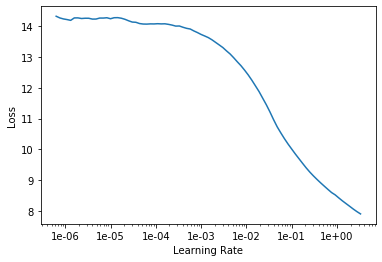

In [90]:
learn.lr_find()
learn.recorder.plot()

In [91]:
from callbacks import CustomActivationStats

In [92]:
learn.data.batch_size = 512
cb = CustomActivationStats(learn,layer_type=nn.Linear)
learn.fit_one_cycle(5,1e-2,callbacks=cb)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.081217,0.063574,0.337992,00:27
1,0.037912,0.035465,0.316987,00:26
2,0.028202,0.041379,0.224079,00:26
3,0.016621,0.029315,0.165213,00:26
4,0.015004,0.019437,0.138880,00:26


In [93]:
learn.fit_one_cycle(5,1e-2,callbacks=cb)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.017637,0.041337,0.159859,00:27
1,0.017842,0.041106,0.167433,00:27
2,0.015114,0.016499,0.132733,00:26
3,0.012694,0.017870,0.129144,00:26
4,0.011860,0.015312,0.126066,00:26


In [110]:
learn.save("model_50dp_stage2")

In [111]:
learn.fit_one_cycle(5,1e-2,callbacks=cb)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.014905,0.029055,0.162660,00:28
1,0.016982,0.024629,0.149573,00:26
2,0.015403,0.017861,0.133831,00:26
3,0.011853,0.017773,0.123804,00:26
4,0.011281,0.016060,0.129991,00:26


In [164]:
# learn.save("model_50dp_stage3")
learn.load("model_50dp_stage3")

Learner(data=TabularDataBunch;

Train: LabelList (802943 items)
x: TabularList
Store 1115; DayOfWeek 5; Year 2015; Month 6; Day 19; StateHoliday False; CompetitionMonthsOpen 0; Promo2Weeks 25; StoreType d; Assortment c; PromoInterval Mar,Jun,Sept,Dec; CompetitionOpenSinceYear 1900; Promo2SinceYear 2012; State HE; Week 25; Events Rain; Promo_fw 1.0; Promo_bw 5.0; StateHoliday_fw 0.0; StateHoliday_bw 0.0; SchoolHoliday_fw 0.0; SchoolHoliday_bw 0.0; CompetitionDistance_na False; CloudCover_na False; CompetitionDistance -0.0130; Max_TemperatureC 0.1333; Mean_TemperatureC 0.4683; Min_TemperatureC 0.8602; Max_Humidity 0.0780; Mean_Humidity -0.3412; Min_Humidity -0.0811; Max_Wind_SpeedKm_h -0.1780; Mean_Wind_SpeedKm_h 0.1902; CloudCover 0.2552; trend 0.4066; trend_DE 0.5969; AfterStateHoliday -0.7329; BeforeStateHoliday 1.1848; Promo 1.1119; SchoolHoliday -0.4796; ,Store 1; DayOfWeek 4; Year 2015; Month 6; Day 18; StateHoliday False; CompetitionMonthsOpen 24; Promo2Weeks 0; StoreType c; Assor

In [165]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): CustomDropout(p=0.05)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [177]:
switch_custom_dropout(learn.model,False,True)

Current active : True
Switching to : False
Current active : True
Switching to : False
Current active : True
Switching to : False


In [178]:
pred,y = learn.get_preds()
mse = learn.loss_func(pred,y)
rmse = exp_rmspe(pred,y)
print(mse)
print(rmse)

tensor(0.0111)
tensor(0.1104)


In [169]:
switch_custom_dropout(learn.model,True,True)

Current active : False
Switching to : True
Current active : False
Switching to : True
Current active : False
Switching to : True


In [171]:
learn.data.batch_size = 512

In [176]:
pred,y = get_preds_sample(learn,n_sample=50)
pred = pred.mean(dim = 0)
mse = learn.loss_func(pred,y)
rmse = exp_rmspe(pred,y)
print(mse)
print(rmse)

tensor(0.0112)
tensor(0.1114)


In [117]:
n_samples = [10,20,30,40,50,60,70]

output = []

for n_sample in n_samples:
    preds, y = get_preds_sample(learn,n_sample=n_sample)
    preds = preds.mean(dim = 0)
    mse = learn.loss_func(preds,y)
    rmse = exp_rmspe(preds,y)
    output.append({"n_sample":n_sample,"mse":mse.item(),"rmse":rmse.item()})

In [120]:
df = pd.DataFrame(output)

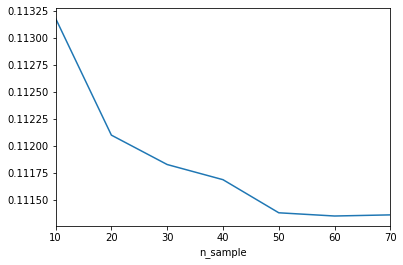

In [123]:
df.set_index("n_sample")["rmse"].plot()

In [28]:
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.024493,1.977525,0.825859,00:25
1,0.181936,39.881496,4.922277,00:25
2,0.182660,33.916901,5.233205,00:25
3,0.182224,57.192619,3.143337,00:26
4,0.181232,17.434303,1.729687,00:25


In [29]:

learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.181483,0.171640,0.484261,00:25
1,0.182618,0.171800,0.488443,00:25
2,0.183509,0.172443,0.464002,00:25
3,0.177584,0.171597,0.477173,00:25
4,0.181350,0.171688,0.473812,00:25


In [30]:
learn.model.layers

Sequential(
  (0): DropLinear(
    (dp): AutoDropout(
      p=-0.00025209318846464157
      (plu): PLU()
    )
    (W): Linear(in_features=233, out_features=1000, bias=True)
  )
  (1): ReLU(inplace=True)
  (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): DropLinear(
    (dp): AutoDropout(
      p=-0.0031922098714858294
      (plu): PLU()
    )
    (W): Linear(in_features=1000, out_features=500, bias=True)
  )
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=500, out_features=1, bias=True)
)

In [62]:
kl.df_stats.module.unique()

array(['0x7f851d11b690', '0x7f851d131310'], dtype=object)

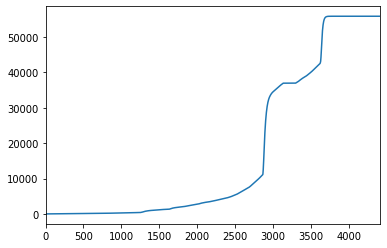

In [63]:
module = "0x7f851d11b690"
df = kl.df_stats
df.loc[df.module == module,"w"].plot()

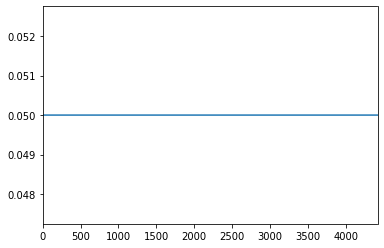

In [64]:
df.dropout.plot()

In [65]:
kl.df_loss

,total_kl,last_loss,total_loss
0,0.005749,14.506405,14.512154
1,0.009022,33.999092,34.008114
2,0.015114,31.497904,31.513018
3,0.023381,27.781738,27.805119
4,0.033452,25.324514,25.357967
...,...,...,...
9964,0.000000,0.007712,0.007712
9965,0.000000,0.011081,0.011081
9966,0.000000,0.009178,0.009178
9967,0.000000,0.007672,0.007672


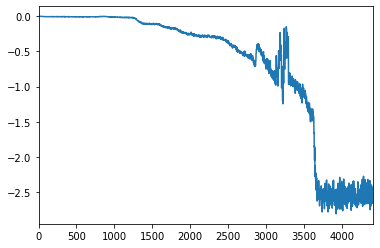

In [66]:
df = cb.df
df = df.loc[df.module == module]
df.m.plot()

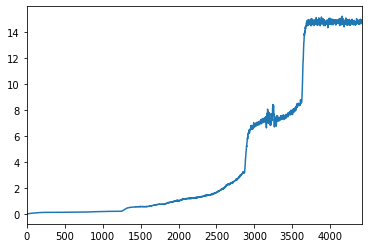

In [67]:
df.s.plot()

(array([  5.,  33.,  65., 139., 226., 184., 161.,  87.,  40.,  10.]),
 array([-38.846794, -31.71825 , -24.589705, -17.46116 , -10.332616,  -3.204071,   3.924474,  11.053019,  18.181562,
         25.310108,  32.438652], dtype=float32),
 <a list of 10 Patch objects>)

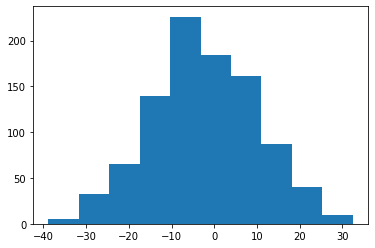

In [69]:
values = np.stack(df.loc[df.module == module,"z"])

i = 2000

row = values[i]
plt.hist(row[row !=  0])

In [25]:
def get_preds_sample(learn,ds_type=DatasetType.Valid,n_sample=10,reduce=None):
  
    preds = []
    for i in range(n_sample):
        pred,y = learn.get_preds(ds_type=ds_type)
        pred = pred.view((1,) + pred.shape)
        preds.append(pred)
    preds = torch.cat(preds)
    if reduce == "mean":
        preds = preds.mean(dim=0)
    return preds,y 

In [26]:
preds,y = get_preds_sample(learn)

In [73]:
pred,y = learn.get_preds()
learn.loss_func(pred,y)

tensor(0.0295)

In [27]:
learn.loss_func(preds.mean(dim=0),y)

tensor(0.2843)

(array([2.6660e+03, 1.2168e+04, 1.4961e+04, 7.7410e+03, 2.7510e+03, 7.7000e+02, 2.5700e+02, 5.3000e+01, 2.0000e+01,
        8.0000e+00]),
 array([0.053721, 0.145447, 0.237173, 0.3289  , 0.420626, 0.512352, 0.604079, 0.695805, 0.787531, 0.879258, 0.970984],
       dtype=float32),
 <a list of 10 Patch objects>)

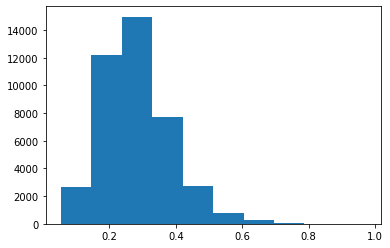

In [33]:
plt.hist(to_np(preds.std(dim=0)).reshape(-1))

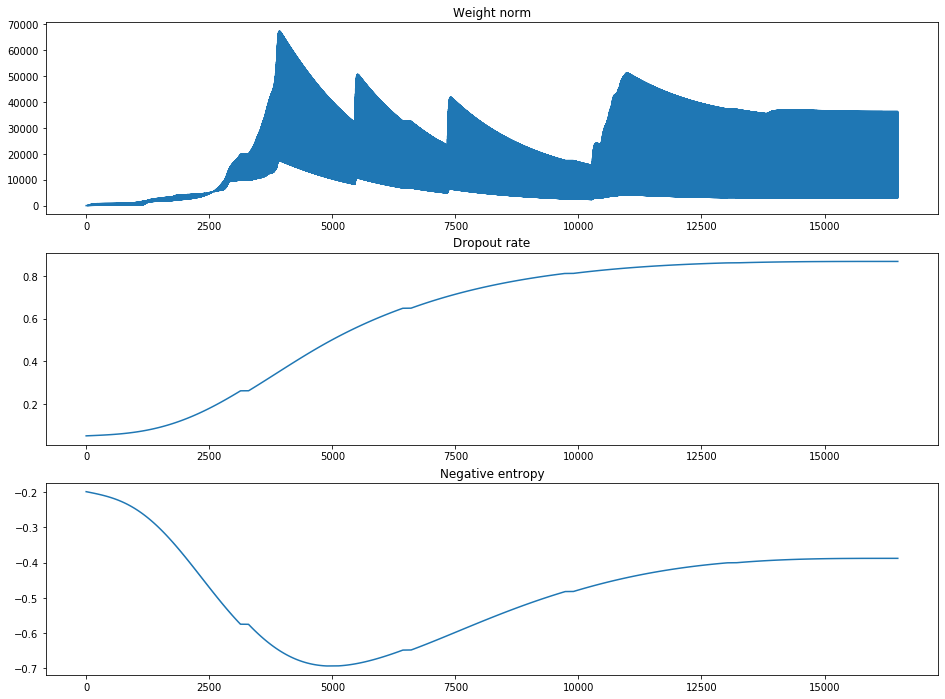

In [23]:
kl.plot_stats()

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.05,0.05], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)
learn.data.batch_size = 512

In [0]:
class CustomDropout(nn.Module):
  def __init__(self,p,activate=True):
    super().__init__()
    self.activate = activate
    self.p = p
    
  def forward(self,x):
    return nn.functional.dropout(x,self.p,training=self.activate)

In [0]:
get_args = lambda dp : {"p":dp.p}
convert_layers(learn.model,nn.Dropout,CustomDropout,get_args=get_args)

In [0]:
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [81]                 90,396     True      
______________________________________________________________________
Embedding            [5]                  40         True      
______________________________________________________________________
Embedding            [3]                  12         True      
______________________________________________________________________
Embedding            [7]                  91         True      
______________________________________________________________________
Embedding            [11]                 352        True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [10]                 260        True      
_________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


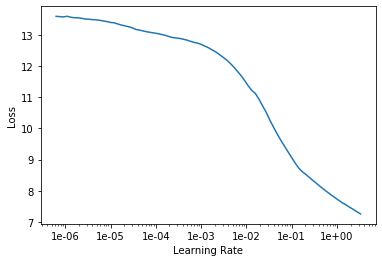

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-3,)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.082807,0.105385,0.322152,00:47
1,0.023083,0.024727,0.165047,00:46
2,0.017177,0.017222,0.147268,00:45
3,0.012182,0.015136,0.130101,00:45
4,0.010656,0.015765,0.138053,00:46


In [0]:
learn.save("model_regular_dp")

In [0]:

x,y = learn.data.one_batch(cpu=False)

In [0]:
pred,y = get_preds_sample(learn,n_sample=10)

In [0]:
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [81]                 90,396     True      
______________________________________________________________________
Embedding            [5]                  40         True      
______________________________________________________________________
Embedding            [3]                  12         True      
______________________________________________________________________
Embedding            [7]                  91         True      
______________________________________________________________________
Embedding            [11]                 352        True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [10]                 260        True      
_________________________________________________

In [0]:
exp_rmspe(pred.mean(dim=0).squeeze(1),y)

tensor(0.1339)

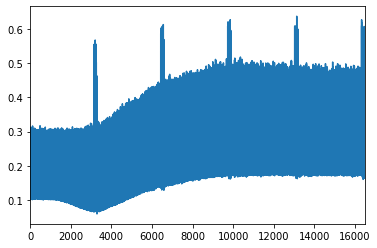

In [0]:
df = pd.DataFrame(cb.stats)
df.s.plot()

In [0]:
df.module.unique()

array(['0x7fa2e6b2a358', '0x7fa2e2d2ec18'], dtype=object)

(array([ 2.,  2., 21., 34., 45., 61., 38., 30., 14.,  7.]),
 array([-1.412846, -1.116899, -0.820951, -0.525004, -0.229057,  0.06689 ,  0.362837,  0.658785,  0.954732,  1.250679,
         1.546626], dtype=float32),
 <a list of 10 Patch objects>)

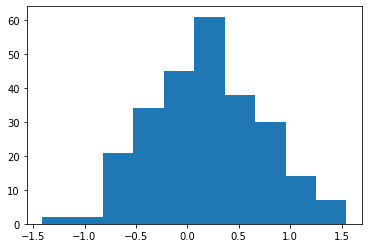

In [0]:
values = np.stack(df.loc[df.module == "0x7fa2e2d2ec18","z"])

i = 

row = values[i]
plt.hist(row[row !=  0])

In [0]:
df.module.unique()

array(['0x7fa2e6b2a358', '0x7fa2e2d2ec18'], dtype=object)

In [0]:
df.w

0        0.001430
1        0.000333
2        0.001430
3        0.000333
4        0.001430
           ...   
16485    0.000333
16486    0.001430
16487    0.000333
16488    0.001430
16489    0.000333
Name: w, Length: 16490, dtype: float64

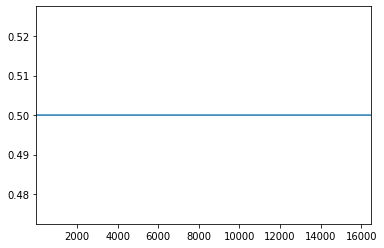

In [0]:
df = pd.DataFrame(kl.stats)
df.loc[df.module == "0x7fa2e2d2ec18","dropout"].plot()

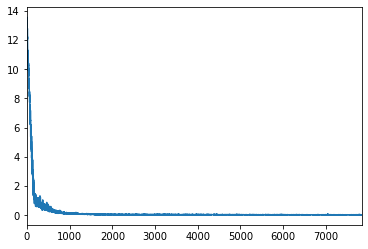

In [0]:
df = pd.DataFrame(kl.loss)
df.last_loss.plot()